In [1]:
import fglib
from fglib import graphs,nodes,rv, inference
import pyldpc
import numpy as np
from random import uniform
import progressbar
from collections import OrderedDict
from scipy.misc import imshow, imresize,imread
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# a) Construct factor graph based on some H

In [2]:
# Generate H
# Reference: https://github.com/hichamjanati/pyldpc-tutos/blob/master/Tutorials/pyLDPC-Tutorial-Basics.ipynb

N = 128  # Number of bits
dim_codeword = 2*N
d_v = 2 # Number of ones per column, must be lower than d_c (because H must have more rows than columns)
d_c = 4 # Number of ones per row, must divide n (because if H has m rows: m*d_c = n*d_v (compute number of ones in H))

H = pyldpc.RegularH(dim_codeword,d_v,d_c)
print("Regular parity-check matrix H({},{},{}):\n\n".format(dim_codeword,d_v,d_c),H)

Regular parity-check matrix H(256,2,4):

 [[1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [3]:
def construct_check_factor(check_fnode):
    nodes_in_check = list(check_fnode.neighbors())
    n_nodes_in_check = len(nodes_in_check)
    pmf_shape = [2]*n_nodes_in_check
    pmf_out = np.zeros(pmf_shape)
    all_idx = np.where(pmf_out==0)
    pmf_values = 1-np.stack(all_idx).sum(0)%2
    pmf_out[all_idx] = pmf_values
    return rv.Discrete(pmf_out, *nodes_in_check)

def construct_prior_factor(prior_fnode, observed_r, error_rate):
    if observed_r==0:
        pmf = np.array([1-error_rate, error_rate])
    else:
        pmf = np.array([error_rate, 1-error_rate])
    return  rv.Discrete(pmf, prior_fnode)

## Factor function checking case

In [4]:
# Suppose we have a fnode that check 3 binary nodes the pmf is generated 
# By following code for this factor
n_nodes_in_check = 3
pmf_shape = [2]*n_nodes_in_check
pmf_out = np.zeros(pmf_shape)
all_idx = np.where(pmf_out==0)
pmf_values = 1-np.stack(all_idx).sum(0)%2
pmf_out[all_idx] = pmf_values

# Can observe that the factor will only evaluate to 1 
# when there are even number of 1 among x1,x2 and x3
for x1 in [0,1]:
    for x2 in [0,1]:
        for x3 in [0,1]:
            print('x1=%d, x2=%d, x3=%d, f(x1,x2,x3)=%d'%(x1,x2,x3,pmf_out[x1][x2][x3]))

x1=0, x2=0, x3=0, f(x1,x2,x3)=1
x1=0, x2=0, x3=1, f(x1,x2,x3)=0
x1=0, x2=1, x3=0, f(x1,x2,x3)=0
x1=0, x2=1, x3=1, f(x1,x2,x3)=1
x1=1, x2=0, x3=0, f(x1,x2,x3)=0
x1=1, x2=0, x3=1, f(x1,x2,x3)=1
x1=1, x2=1, x3=0, f(x1,x2,x3)=1
x1=1, x2=1, x3=1, f(x1,x2,x3)=0


## Construct graph using fglib

In [5]:
# Construct factor graph
def construct_graph_with_H_and_observations(H, observations, error_rate=0.05):
    n_checks, n_bits = H.shape
    # Construct empty factor graph
    factor_graph = graphs.FactorGraph()
    # Construct bits V nodes
    bits_vnodes = [nodes.VNode('x%d'%n) for n in range(n_bits)]
    # Construct checks F nodes
    checks_fnodes = [nodes.FNode('h%d'%m) for m in range(n_checks)]
    # Construct priors F nodes
    priors_fnodes = [nodes.FNode('f%d'%m) for m in range(n_bits)]
    
    # Register Nodes to the graph
    factor_graph.set_nodes(priors_fnodes)
    factor_graph.set_nodes(bits_vnodes)
    factor_graph.set_nodes(checks_fnodes)
    
    # Construct Edges between priors and bits
    factor_graph.set_edges(zip(priors_fnodes, bits_vnodes))
    # Constrct Edges between bits and checks
    check_idx, bit_idx = np.where(H==1)
    for m, n in zip(check_idx, bit_idx):
        factor_graph.set_edge(checks_fnodes[m], bits_vnodes[n])
    
    # Initialize check factors
    for check_fnode in checks_fnodes:
        check_fnode.factor = construct_check_factor(check_fnode)
        # Initialize message rmn to 1 so that we can call belief() before iteration
        for bit_vnode in check_fnode.neighbors():
            edge = factor_graph.get_edge_data(check_fnode, bit_vnode)['object']
            message = rv.Discrete([1,1], bit_vnode)
            edge.set_message(check_fnode, bit_vnode, message)
    # Initialize prior factors
    for prior_fnode, observed_r in zip(priors_fnodes, observations):
        prior_fnode.factor = construct_prior_factor(prior_fnode,observed_r,error_rate)
        
    # Initialize message hm->xn and fn->xn
    for prior_fnode,bit_vnode in zip(priors_fnodes, bits_vnodes):
        # initialize prior message so that we can call belief() before iteration
        prior_message = prior_fnode.spa(bit_vnode).normalize()
        factor_graph.get_edge_data(prior_fnode, bit_vnode)['object'].set_message(prior_fnode, bit_vnode, prior_message)
        # Initialize qmn
        checks_for_this_node = bit_vnode.neighbors(prior_fnode)
        message = prior_fnode.factor.pmf
        message = rv.Discrete(message, bit_vnode)
        for check in checks_for_this_node:
            edge = factor_graph.get_edge_data(bit_vnode, check)['object']
            edge.set_message(bit_vnode, check, message)  
    return factor_graph

In [6]:
# Update belief given a edge visiting schedule
def schedule_propagation(schedule, graph):
    '''
    schedule: list of edges (in tuple form)parralel_update
    '''
    for node_origin, node_destination in schedule:
        # Get fglib edge object
        edge = graph.get_edge_data(node_origin, node_destination)['object']
        # get message using sum-product algorithm
        #print('%s --> %s'%(node_origin, node_destination))
        message = node_origin.spa(node_destination).normalize()
        # set message
        edge.set_message(node_origin,node_destination,message)
    return 

def get_beliefs(fg, n_iteration=10, parallel_update=True, saving_iterations=[]):
    # If acyclic use depth first search to generate a efficient schedule
    if not parallel_update:
        root_node = list(fg.get_vnodes())[0]
        root2leaf = list(nx.depth_first_search.dfs_edges(fg, root_node))
        leaf2root = [(v,u) for u,v in reversed(root2leaf)]
        schedule_propagation(leaf2root, fg)
        schedule_propagation(root2leaf, fg)
        
    # Otherwise, use iterative updating (Loopy propagation)
    else:
        fnodes = fg.get_fnodes()
        vnodes = fg.get_vnodes()
        nodes_sequence = fnodes + vnodes
        schedule = [(node, neighbor) for node in nodes_sequence for neighbor in node.neighbors()]
        bar = progressbar.ProgressBar()
        #print('Iterating')
        output_dict = OrderedDict([(str(vnode), []) for vnode in fg.get_vnodes()])
        for i in bar(range(n_iteration)):
            if i in saving_iterations:
                for vnode in vnodes:
                    output_dict[str(vnode)].append(vnode.belief().pmf)
            # Propagate
            schedule_propagation(schedule, fg)
            
    # Final configuration saving
    for vnode in vnodes:
                    output_dict[str(vnode)].append(vnode.belief().pmf)
    return output_dict

# b) Decoding Test on all zero codeword

In [7]:
# Original message: 
codeword = np.zeros(256, dtype=int)

In [8]:
# Define binary symmetric channel
def binary_symmetric_channel(codeword, error_rate):
    error_bits_idx = np.where(np.random.choice([0,1], p=(1-error_rate,error_rate),size=codeword.shape)==1)[0] 
    corrupted = codeword.copy()
    corrupted[error_bits_idx] = 1-corrupted[error_bits_idx]
    return corrupted

100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04


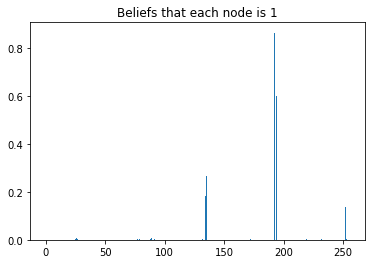

In [9]:
# Generate received codeword
received = binary_symmetric_channel(codeword, 0.05)
fg = construct_graph_with_H_and_observations(H, received)
beliefs = get_beliefs(fg,n_iteration=50, saving_iterations=np.arange(0,50,1))
# Decode codeword based on posterior belief
def decode_based_on_beliefs(beliefs):
    results_for_each_node = np.array([[belief.argmax() for belief in node_beliefs] 
                                      for node_beliefs in beliefs.values()])
    return results_for_each_node.T
decoded_codeword = decode_based_on_beliefs(beliefs)
# Get final beliefs
final_beliefs_on_1 = [belief_list[-1][1] for belief_list in beliefs.values()]
# Plot the results
bar_position = np.arange(len(final_beliefs_on_1))
plt.bar(bar_position,final_beliefs_on_1)
plt.title('Beliefs that each node is 1')

# c) Hamming Distance plot

In [10]:
def do_n_trial_and_plot_results(n, error_rate=0.06):
    beliefs_list = []
    for _ in range(10):
        received = binary_symmetric_channel(codeword, 0.10)
        fg = construct_graph_with_H_and_observations(H, received, 0.10)
        beliefs = get_beliefs(fg,n_iteration=50, saving_iterations=np.arange(50))
        beliefs_list.append(beliefs)

    decoded_codewords_list = [decode_based_on_beliefs(beliefs) for beliefs in beliefs_list]

    from scipy.spatial.distance import hamming
    from functools import partial
    def get_hamming_distances(original_codeword, decoded_codewords):
        get_hamming_distances_from_original = partial(hamming, v=original_codeword)
        hamming_distances = np.apply_along_axis(arr=decoded_codewords, func1d=get_hamming_distances_from_original, axis=1)
        return hamming_distances

    hamming_dist_vs_iter_list = [get_hamming_distances(codeword, decoded_codewords) for decoded_codewords in decoded_codewords_list]

    [plt.plot(np.arange(51),hamming_dist_vs_iter) for hamming_dist_vs_iter in hamming_dist_vs_iter_list]
    plt.title('%d trail with error rate: %.4f'%(n, error_rate))

100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04


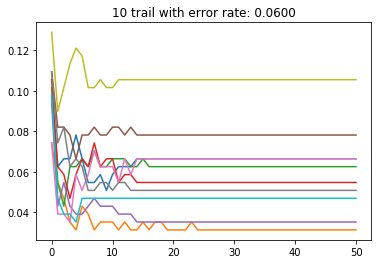

In [11]:
do_n_trial_and_plot_results(10,0.06)

100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04


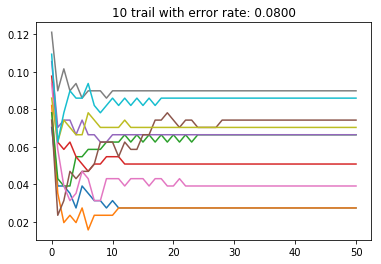

In [12]:
do_n_trial_and_plot_results(10,0.08)

100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04
100% (50 of 50) |#########################| Elapsed Time: 0:00:04 Time: 0:00:04


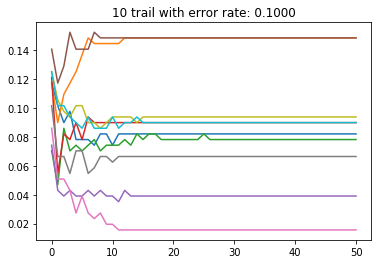

In [13]:
do_n_trial_and_plot_results(10,0.10)

# Part 3 Image example

In [14]:
# Load real size images

In [15]:
# Load and compress image
nyu_logo_realsize_color = imread('./photo.jpg')
nyu_logo_compressed_color = imresize(nyu_logo_realsize_color, (40,40))

In [16]:
nyu_logo_compressed_color.shape

(40, 40, 3)

In [17]:
def to_binary(img, threshold=127):
    binary = img.mean(2)>threshold
    return binary.astype(int)

In [18]:
# Change to binary bits
nyu_logo_binary_compressed = to_binary(nyu_logo_compressed_color,180)

In [19]:
# Construct 1600-bit message
nyu_logo_1600bit_message = nyu_logo_binary_compressed.reshape(-1)

In [20]:
# Encoding
n = 1600*2
d_v = 4
d_c = 8
H = pyldpc.RegularH(n, d_v, d_c)

In [21]:
H.shape

(1600, 3200)

In [22]:
new_H, sys_tG = pyldpc.CodingMatrix_systematic(H, use_sparse=True)

In [23]:
def generate_codeword(message, tG, error_rate):
    diff_dim = tG.shape[1]-message.shape[0]
    # Extend the original message to match generator
    message_extended = np.array(nyu_logo_1600bit_message.tolist()+[0]*diff_dim)
    codeword = binary_symmetric_channel(tG.dot(message_extended)%2, error_rate=error_rate)
    return codeword

In [49]:
# Generate codeword
nyu_logo_codeword = generate_codeword(nyu_logo_1600bit_message, sys_tG, error_rate=0.06)
# Decode
# Construct graph
fg_nyu_logo_codeword = construct_graph_with_H_and_observations(new_H, observations=nyu_logo_codeword, error_rate=0.06)
beliefs = get_beliefs(fg_nyu_logo_codeword, n_iteration=30, saving_iterations=[1,2,3,5,10,20])
decoded_prediction = decode_based_on_beliefs(beliefs)

100% (30 of 30) |#########################| Elapsed Time: 0:01:32 Time: 0:01:32


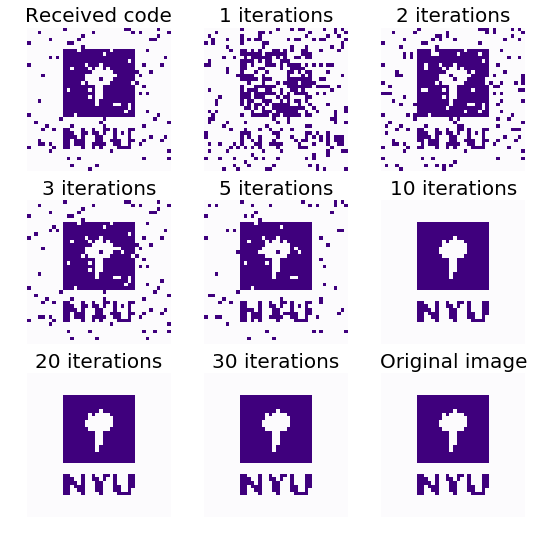

In [50]:
# Result plot
fig, axs = plt.subplots(3,3, figsize=(9, 9), facecolor='w', edgecolor='k')
axs = axs.reshape(-1)
iterations = [1,2,3,5,10,20,30]
ax0 = axs[0]
axs = axs[1:]
ax0.imshow(nyu_logo_codeword[:1600].reshape(40,40), cmap='Purples')
ax0.set_title('Received code', fontsize=20)
ax0.set_axis_off()
for i,prediction in enumerate(decoded_prediction):
    img_arr = prediction[:1600].reshape(40,40)
    axs[i].imshow(img_arr, cmap='Purples')
    axs[i].set_title('%d iterations'%iterations[i], fontsize=20)
    axs[i].set_axis_off()
axs[-1].imshow(nyu_logo_binary_compressed, cmap='Purples')
axs[-1].set_title('Original image', fontsize=20)
axs[-1].set_axis_off()

# Part f

In [24]:
# Generate codeword
nyu_logo_codeword = generate_codeword(nyu_logo_1600bit_message, sys_tG, error_rate=0.10)
# Decode
# Construct graph
fg_nyu_logo_codeword = construct_graph_with_H_and_observations(new_H, observations=nyu_logo_codeword, error_rate=0.10)
beliefs = get_beliefs(fg_nyu_logo_codeword, n_iteration=30, saving_iterations=[1,2,3,5,10,20])
decoded_prediction = decode_based_on_beliefs(beliefs)

100% (30 of 30) |#########################| Elapsed Time: 0:01:36 Time: 0:01:36


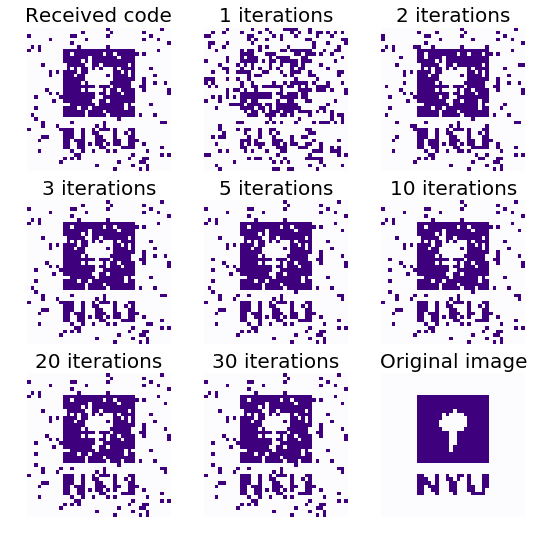

In [25]:
# Result plot
fig, axs = plt.subplots(3,3, figsize=(9, 9), facecolor='w', edgecolor='k')
axs = axs.reshape(-1)
iterations = [1,2,3,5,10,20,30]
ax0 = axs[0]
axs = axs[1:]
ax0.imshow(nyu_logo_codeword[:1600].reshape(40,40), cmap='Purples')
ax0.set_title('Received code', fontsize=20)
ax0.set_axis_off()
for i,prediction in enumerate(decoded_prediction):
    img_arr = prediction[:1600].reshape(40,40)
    axs[i].imshow(img_arr, cmap='Purples')
    axs[i].set_title('%d iterations'%iterations[i], fontsize=20)
    axs[i].set_axis_off()
axs[-1].imshow(nyu_logo_binary_compressed, cmap='Purples')
axs[-1].set_title('Original image', fontsize=20)
axs[-1].set_axis_off()